In [1]:
import os
import tensorflow as tf
import numpy as np
import json
import random

SEED = 1234
tf.random.set_seed(SEED)

In [2]:
#Creation of data generator objects

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(brightness_range=[0.5,1.5],
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest',#when we flip, rotate, we introduce new pixels and we must set a way on how to fill
                                       cval=0,
                                       rescale=1/255.)

else:
    train_data_gen = ImageDataGenerator(rescale=1/255.)
    
valid_data_gen = ImageDataGenerator(rescale=1/255.)


In [3]:
#Setting paths for training, validation and test set

cwd = os.path.join(os.path.dirname(os.getcwd()),"artificial-neural-networks-and-deep-learning-2020/MaskDataset/")

dataset_dir = os.path.join(cwd, "training/")
validation_dir = os.path.join(cwd, "validation/")
test_dir = os.path.join(cwd, "test/")

In [4]:
path = os.getcwd()
print ("The current working directory is %s" % test_dir)

The current working directory is C:\Users\ASUS\Documents\Università\ANNDL\artificial-neural-networks-and-deep-learning-2020/MaskDataset/test/


In [5]:
with open(os.path.join(cwd,'train_gt.json')) as f:
  myJson = json.load(f)
print(myJson)

{'14985.jpg': 0, '13358.jpg': 0, '10210.jpg': 0, '18202.jpg': 0, '14962.jpg': 0, '13243.jpg': 0, '11116.jpg': 0, '14251.jpg': 0, '15818.jpg': 0, '15552.jpg': 0, '16795.jpg': 0, '15952.jpg': 0, '11918.jpg': 0, '11657.jpg': 0, '11150.jpg': 0, '14006.jpg': 0, '11271.jpg': 0, '10935.jpg': 0, '16664.jpg': 0, '15919.jpg': 0, '14038.jpg': 0, '18138.jpg': 0, '13709.jpg': 0, '10410.jpg': 0, '11966.jpg': 0, '12230.jpg': 0, '16157.jpg': 0, '13944.jpg': 0, '17170.jpg': 0, '16603.jpg': 0, '16910.jpg': 0, '14724.jpg': 0, '13580.jpg': 0, '17098.jpg': 0, '10634.jpg': 0, '15741.jpg': 0, '11158.jpg': 0, '16290.jpg': 0, '16503.jpg': 0, '12982.jpg': 0, '12581.jpg': 0, '13975.jpg': 0, '13113.jpg': 0, '12834.jpg': 0, '18002.jpg': 0, '16344.jpg': 0, '12968.jpg': 0, '14342.jpg': 0, '13133.jpg': 0, '12859.jpg': 0, '15476.jpg': 0, '14589.jpg': 0, '13468.jpg': 0, '14427.jpg': 0, '13787.jpg': 0, '10603.jpg': 0, '18004.jpg': 0, '16903.jpg': 0, '15523.jpg': 0, '18030.jpg': 0, '12960.jpg': 0, '14212.jpg': 0, '10172.

#division of images in different set

for key in myJson:
    os.rename(os.path.join(dataset_dir,key), dataset_dir+'/'+str(myJson[key])+'/'+key)

In [6]:
#reset validation set to empty set
for i in range(3):
    curr_dir = os.path.join(cwd, "validation/" + str(i))
    image_filenames = next(os.walk(curr_dir))[2]

    for image_name in image_filenames:
        os.rename(os.path.join(curr_dir,image_name), dataset_dir+'/'+str(myJson[image_name])+'/'+image_name)

In [7]:
#choose 5% random images from the training set and move them to validation set
random.seed(SEED)

for i in range(3):
    curr_dir = os.path.join(cwd, "training/" + str(i))
    image_filenames = next(os.walk(curr_dir))[2]

    for image_name in image_filenames:
        if 100*random.random() < 3:
            os.rename(os.path.join(curr_dir,image_name), validation_dir+'/'+str(myJson[image_name])+'/'+image_name)
    


In [8]:
#Generators for reading images dirrectly from directories

img_h = 256
img_w = 256

bs=16

#training generator
train_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               target_size=(img_h,img_w),
                                              color_mode='rgb',
                                              batch_size=bs,
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=SEED)
#validation generator
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                              batch_size=bs,
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=SEED)


Found 5465 images belonging to 3 classes.
Found 149 images belonging to 3 classes.


In [9]:
#creation of dataset objects
num_classes = 3

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                              output_types=(tf.float32,tf.float32),
                                              output_shapes=([None,img_h,img_w,3],[None,num_classes]))

train_dataset=train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                              output_types=(tf.float32,tf.float32),
                                              output_shapes=([None,img_h,img_w,3],[None,num_classes]))

valid_dataset=valid_dataset.repeat()

In [10]:
import matplotlib.pyplot as plt

iterator = iter(train_dataset)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

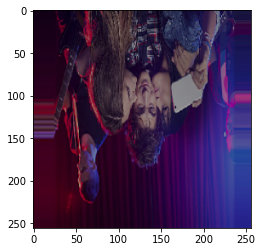

In [11]:
augmented_img, target = next(iterator)
augmented_img = np.array(augmented_img[0])
augmented_img = augmented_img * 255

plt.imshow(np.uint8(augmented_img))
plt.plot

In [16]:
# Load VGG16 Model

vgg = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()

# Create Model
# ------------

finetuning = True

if finetuning:
    freeze_until = 250 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False
    
model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=16, activation='elu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
#model.weights

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, 127, 127, 32) 96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 127, 127, 32) 0           batch_normalization_406[0][0]    
________________________________________________________________________________

__________________________________________________________________________________________________
block8_3_conv (Conv2D)          (None, 6, 6, 2080)   933920      block8_3_mixed[0][0]             
__________________________________________________________________________________________________
block8_3 (Lambda)               (None, 6, 6, 2080)   0           block8_2_ac[0][0]                
                                                                 block8_3_conv[0][0]              
__________________________________________________________________________________________________
block8_3_ac (Activation)        (None, 6, 6, 2080)   0           block8_3[0][0]                   
__________________________________________________________________________________________________
conv2d_582 (Conv2D)             (None, 6, 6, 192)    399360      block8_3_ac[0][0]                
__________________________________________________________________________________________________
batch_norm

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                884752    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 55,221,539
Trainable params: 53,560,707
Non-trainable params: 1,660,832
_________________________________________________________________


In [17]:
#Loss function
loss = tf.keras.losses.CategoricalCrossentropy()

#Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Validation metric used during training
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss , metrics=metrics)

In [18]:
#Callbacks list

from datetime import datetime

exps_dir = os.path.join(os.getcwd(),'weights')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name='FC'

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

ckpt_dir = os.path.join(exp_dir,'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

#Checkpoint callback
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir,'cp.ckpt'),save_weights_only=True,save_best_only=True)

callbacks.append(ckpt_callback)

#tensorboard callback
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
tb_callback=tf.keras.callbacks.TensorBoard(log_dir=tb_dir,histogram_freq=1)


# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    callbacks.append(es_callback)



In [ ]:
#model.load_weights(filepath='C:\\Users\\ASUS\\Documents\\Università\\ANNDL\\A2NDLKaggle\\weights\\FC_Nov14_15-02-54\\ckpts\\cp.ckpt')


model.fit(x=train_dataset,
         epochs=100,
         steps_per_epoch=len(train_gen),
         validation_data=valid_dataset,
         validation_steps=len(valid_gen),
         callbacks=callbacks)

Train for 342 steps, validate for 10 steps
Epoch 1/100
342/342 [==============================] - 333s 975ms/step - loss: 0.7392 - accuracy: 0.6339 - val_loss: 0.4713 - val_accuracy: 0.7852
Epoch 2/100
342/342 [==============================] - 305s 893ms/step - loss: 0.5120 - accuracy: 0.7629 - val_loss: 0.4002 - val_accuracy: 0.8255
Epoch 3/100
342/342 [==============================] - 301s 881ms/step - loss: 0.4175 - accuracy: 0.8172 - val_loss: 0.3118 - val_accuracy: 0.8792
Epoch 4/100
342/342 [==============================] - 302s 883ms/step - loss: 0.3490 - accuracy: 0.8591 - val_loss: 0.3432 - val_accuracy: 0.8859
Epoch 5/100
342/342 [==============================] - 303s 886ms/step - loss: 0.3017 - accuracy: 0.8801 - val_loss: 0.2143 - val_accuracy: 0.9195
Epoch 6/100
342/342 [==============================] - 301s 880ms/step - loss: 0.2726 - accuracy: 0.8911 - val_loss: 0.4160 - val_accuracy: 0.8792
Epoch 7/100


In [ ]:
#Function for creating the result in a csv file



from datetime import datetime

def create_csv(results, results_dir='./results'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')




In [ ]:
#Prediction computation done one image at time

#model.load_weights(filepath='C:\\Users\\ASUS\\Documents\\Università\\ANNDL\\A2NDLKaggle\\weights\\FC_Nov18_19-18-42\\ckpts\\cp.ckpt')


from PIL import Image

image_filenames = next(os.walk(test_dir))[2]

results = {}
for image_name in image_filenames:
    
    image = tf.keras.preprocessing.image.load_img(test_dir+image_name,target_size=(img_h,img_w))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    
    predictions = model.predict_classes(input_arr*(1/255))
    #img = Image.open(test_dir+'/'+image_name).convert('RGB')
    #img_array = np.array(img)
    #img_array = np.expand_dims(img_array, 0) 
    #data_normalization
    #print(np.argmax(predictions, axis=1)[0] )

    #prediction = argmax(softmax)   # predicted class
    

    #results[image_name] = np.argmax(predictions, axis=1) [0]
    
    results[image_name] = predictions[0]

create_csv(results)
print (results)

In [ ]:
model.save_weights(filepath=os.path.join(cwd,'cp.ckpt'))

In [ ]:
print(cwd)

In [ ]:
image = tf.keras.preprocessing.image.load_img(test_dir+image_name,target_size=(img_h,img_w))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])*1/255
print(input_arr.shape)

#augmented_img = augmented_img * 255
print (input_arr)

plt.imshow(np.uint8(input_arr*255)[0])
plt.plot